![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

X['M_Camry'] = pd.factorize(X.M_Camry)[0]
X['M_Camry4dr'] = pd.factorize(X.M_Camry4dr)[0]
X['M_CamryBase'] = pd.factorize(X.M_CamryBase)[0]
X['M_CamryL'] = pd.factorize(X.M_CamryL)[0]
X['M_CamryLE'] = pd.factorize(X.M_CamryLE)[0]
X['M_CamrySE'] = pd.factorize(X.M_CamrySE)[0]
X['M_CamryXLE'] = pd.factorize(X.M_CamryXLE)[0]

In [4]:
X

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,2014,6480,0,0,0,0,0,0,0
11,2014,39972,0,0,0,1,1,0,0
167,2016,18989,0,0,0,1,0,1,0
225,2014,51330,0,0,0,0,0,0,0
270,2007,116065,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
399845,2017,7542,0,0,0,1,0,1,0
399928,2014,49685,0,0,0,1,0,1,0
399934,2009,104692,0,0,1,1,0,0,0
399951,2010,105077,0,1,0,1,0,0,0


In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
X_train

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,2014,39988,0,0,0,1,0,1,0
333638,2007,38904,0,0,0,1,1,0,0
234716,2016,29607,0,0,0,1,0,1,0
208752,2014,50756,0,0,0,1,0,1,0
348892,2017,10506,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
218085,2010,84057,0,0,0,1,1,0,0
198455,2012,93770,0,1,0,1,0,0,0
205572,2010,88644,0,0,1,1,0,0,0
33541,2015,26180,0,0,0,1,0,1,0


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [7]:
# Definición de la clase DecisionTree
class DecisionTree:
    def __init__(self, j=None, split=None, value=None):
        self.j = j          # índice de la característica (columna) en la que se divide
        self.split = split  # valor de corte
        self.value = value  # valor de predicción si es una hoja
        self.left = None    # subárbol izquierdo
        self.right = None   # subárbol derecho
# Definición de la función gini_impurity para calcular la impureza de Gini
def gini_impurity(X_column, y, split):
    # Calcula la impureza de Gini para un nodo dado
    left_mask = X_column < split
    right_mask = ~left_mask
    # Número de muestras en cada lado del split
    n_left = np.sum(left_mask)
    n_right = np.sum(right_mask)
    # Calcula la proporción de muestras de cada clase en cada lado del split
    p_left = np.sum(y[left_mask] == 1) / n_left
    p_right = np.sum(y[right_mask] == 1) / n_right
    # Calcula la impureza de Gini
    impurity_left = 1 - p_left ** 2 - (1 - p_left) ** 2 if n_left > 0 else 0
    impurity_right = 1 - p_right ** 2 - (1 - p_right) ** 2 if n_right > 0 else 0
    # Combina la impureza de cada lado ponderada por el número de muestras
    total_samples = n_left + n_right
    gini = (n_left / total_samples) * impurity_left + (n_right / total_samples) * impurity_right
    return gini
# Definición de la función best_split para calcular la mejor división de un nodo
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct + 1)).tolist())
        splits = np.unique(splits)[1:]
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    return best_split
# Entrenar el árbol
def train_tree(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        tree = DecisionTree()
        tree.value = y.mean()
        return tree
    j, split, gain = best_split(X, y, num_pct)
    if gain < min_gain:
        tree = DecisionTree()
        tree.value = y.mean()
        return tree
    if max_depth is not None:
        if level >= max_depth:
            tree = DecisionTree()
            tree.value = y.mean()
            return tree
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree = DecisionTree(j, split)
    tree.left = train_tree(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree.right = train_tree(X_r, y_r, level + 1, min_gain, max_depth, num_pct)
    return tree
# Definición de la función predict_tree para hacer predicciones con el árbol entrenado
def predict_tree(tree, x):
    if tree.value is not None:
        return tree.value
    elif x[tree.j] < tree.split:
        return predict_tree(tree.left, x)
    else:
        return predict_tree(tree.right, x)

# Entrenar el árbol
tree_manual = train_tree(X_train, y_train, max_depth=6, num_pct=10)
# Hacer predicciones sobre el conjunto de prueba
y_pred_test = [predict_tree(tree_manual, x) for _, x in X_test.iterrows()]
# Calcular el error cuadrático medio (RMSE) y el error absoluto medio (MAE)
rmse_treeman = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_treeman = mean_absolute_error(y_test, y_pred_test)
print("RMSE el modelo manual:", rmse_treeman)
print("MAE del modelo manual:", mae_treeman)

RMSE el modelo manual: 3912.108137680816
MAE del modelo manual: 3111.622230591807


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
# Creación de 10 muestras bootstrap

np.random.seed(1)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([5157,  235, 3980, ..., 5885, 6315, 1042]),
 array([1355, 2413, 2767, ..., 6766, 5653, 5649]),
 array([6521, 4510, 3100, ..., 1748, 1275, 6960]),
 array([3411,  872,  991, ..., 5725, 2067, 3268]),
 array([4307, 3515, 2971, ...,   32, 7019, 4849]),
 array([5509, 1696, 6764, ..., 6295, 5079, 2704]),
 array([2520, 5009, 2870, ..., 1879, 3963, 2014]),
 array([1599,   12, 4134, ..., 2000,  266, 6961]),
 array([3237, 5597, 6457, ..., 5232, 4138, 1392]),
 array([1687, 3011, 2474, ..., 5202, 6015, 3153])]

In [9]:
# Entrenamiento de un árbol de decisión para cada muestra boostrap

treereg = DecisionTreeRegressor(max_depth=None, random_state=1)
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

for i, sample in enumerate(samples):
    X_train_2 = X_train.iloc[sample, 0:]
    y_train_2 = y_train.iloc[sample]
    treereg.fit(X_train_2, y_train_2)
    y_pred.iloc[:,i] = treereg.predict(X_test)

y_pred

,0,1,2,3,4,5,6,7,8,9
257343,13993.0,13649.0,13990.0,13649.0,13993.0,11788.0,11788.0,11788.0,13649.0,11788.0
326011,6987.0,5995.0,5995.0,6987.0,5980.0,6987.0,6987.0,5995.0,5995.0,5995.0
242354,16491.0,16491.0,16491.0,16995.0,16509.0,16322.0,16491.0,16491.0,15995.0,16491.0
266376,15900.0,22500.0,21990.0,22500.0,21990.0,21990.0,15900.0,22500.0,21990.0,22500.0
396954,15988.0,17900.0,16951.0,15988.0,18995.0,15988.0,17900.0,16951.0,16951.0,16951.0
...,...,...,...,...,...,...,...,...,...,...
144298,14800.0,15995.0,14800.0,13970.0,15121.0,15995.0,14800.0,15995.0,13836.0,14800.0
364521,15700.0,14851.0,16900.0,15999.0,15999.0,14999.0,14851.0,15000.0,16900.0,14851.0
120072,17700.0,23533.0,23533.0,23533.0,23533.0,23533.0,23533.0,23533.0,23533.0,23533.0
99878,13511.0,12989.0,12991.0,10995.0,12893.0,12991.0,12991.0,12991.0,12991.0,12893.0


In [10]:
y_pred.mean(axis=1)
rmse_bgg_mnl = np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
mae_bgg_mnl = mean_absolute_error(y_test, y_pred.mean(axis=1))

print("RMSE el modelo Bagging manual:", rmse_bgg_mnl)
print("MAE del modelo Bagging manual:", mae_bgg_mnl)

RMSE el modelo Bagging manual: 1778.9872466818279
MAE del modelo Bagging manual: 1329.9931254811395


**Respuesta 2**

El modelo Bagging manual presenta un mejor desempeño que el árbol de decisión del punto anterior, ya que combina la predicción de 10 árboles de decisión entrenados con diferentes conjuntos de datos, lo que mejora la precisión del modelo.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [11]:
# Celda 3

n_features = X_train.shape[1]
bagreg = BaggingRegressor(DecisionTreeRegressor(max_features=int(np.log(n_features))), n_estimators=10, 
                          random_state=1)

bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)

rmse_bgg_lib = np.sqrt(mean_squared_error(y_test, y_pred))
mae_bgg_lib = mean_absolute_error(y_test, y_pred)

print("RMSE el modelo Bagging librería:", rmse_bgg_lib)
print("MAE del modelo Bagging librería:", mae_bgg_lib)

RMSE el modelo Bagging librería: 1820.2984738449181
MAE del modelo Bagging librería: 1361.2851149121118


**Respuesta 3**

Se puede observar que el modelo Bagging entrenado con la librería y con el parámetro `max_features` igual a `log(n_features)` tiene un peor desempeño que el modelo realizado manualmente. Esto podría darse porque el parámetro máximo de variables para tener en cuenta en cada bifurcación no es el mejor.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 4

regRF4 = RandomForestRegressor(random_state=1)
regRF4.fit(X_train, y_train)
y_pred_RF4 = regRF4.predict(X_test)

rmse_RF4 = np.sqrt(mean_squared_error(y_test, y_pred_RF4))
mae_RF4 = mean_absolute_error(y_test, y_pred_RF4)

print("RMSE el modelo Random Forest sin calibrar", rmse_RF4)
print("MAE del modelo Random Forest sin calibrar", mae_RF4)

RMSE el modelo Random Forest sin calibrar 1755.5909961992643
MAE del modelo Random Forest sin calibrar 1307.0099154455934


**Respuesta 4**

Para este caso obtenemos un RMSE significativamente peor que los modelos realizados en puntos anteriores. Normalmente esta situación no debería presentarse dada la alta capacidad predictiva de los modelos Random forest, sin embargo se puede mejorar este modelo realizando una calibración óptima para los parametros del modelo. Para este punto se entrenó el modelo random Forest con los parámetros por defecto.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Text(0, 0.5, 'RMSE')

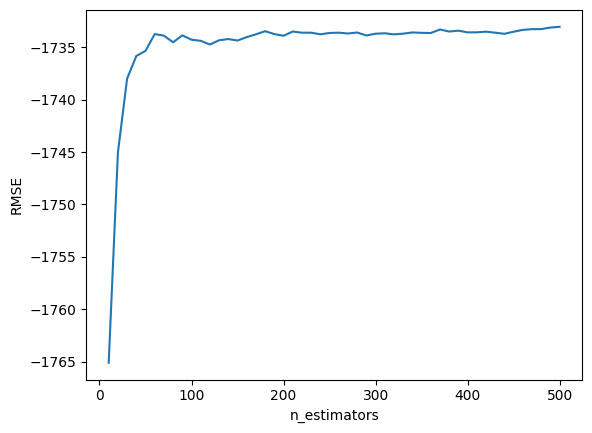

In [13]:
# Celda 5

# Calibración de n_estimators

estimator_range = range(10, 510, 10)
rmse_scores = []

for estimator in estimator_range:
    regRF5_1 = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rmse_scores.append(cross_val_score(regRF5_1, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

Text(0, 0.5, 'RMSE')

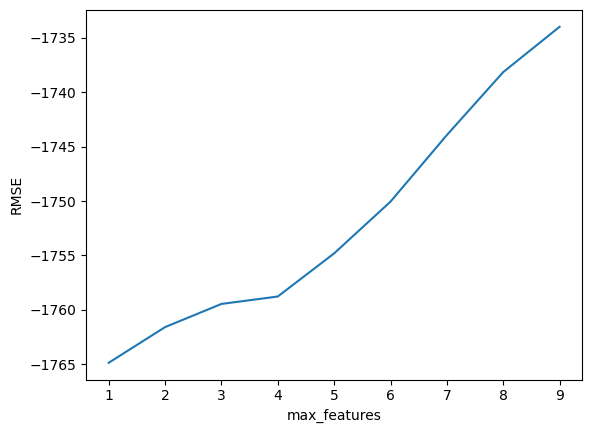

In [14]:
# Calibración de max_features

feature_cols = X_train.columns.tolist()
feature_range = range(1, len(feature_cols)+1)

rmse_scores2 = []

for feature in feature_range:
    regRF5_2 = RandomForestRegressor(n_estimators=98, max_features=feature, random_state=1, n_jobs=-1)
    rmse_scores2.append(cross_val_score(regRF5_2, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

plt.plot(feature_range, rmse_scores2)
plt.xlabel('max_features')
plt.ylabel('RMSE')

In [15]:
regRF5_def = RandomForestRegressor(n_estimators=98, max_features=9, random_state=1, n_jobs=-1)
regRF5_def.fit(X_train, y_train)

y_pred_regRF5_def = regRF5_def.predict(X_test)

rmse_regRF5_def = np.sqrt(mean_squared_error(y_test, y_pred_regRF5_def))
mae_regRF5_def = mean_absolute_error(y_test, y_pred_regRF5_def)

print("RMSE el modelo Random Forest calibrado", rmse_regRF5_def)
print("MAE del modelo Random Forest calibrado", mae_regRF5_def)

RMSE el modelo Random Forest calibrado 1754.9302416581834
MAE del modelo Random Forest calibrado 1306.4888195305855


**Respuesta 5**

En este caso no se evidencia una mejora significativa en el modelo Random Forest con los parámetros calibrados con respecto al mismo modelo sin calibrar. Se puede observar que el RMSE disminuye significativamente cuando el numero de estimadores es menor a 90 aproximadamente, de 90 en adelante se puede observar que la curva se aplana, por lo cual se toma el primer pico mas alto (98) para la calibración del modelo.

Posteriormente vemos como el RMSE tiene una relación inversamente proporcional al número de variables a tener en cuenta para cada una de las bifurcaciones, por lo cual se da como parámetro que se deben tener en cuenta las 9 variables predictoras del conjunto de entrenamiento.

Por último se concluye que el modelo Random Forest con los parámetros calibrados, es el mejor modelo entrenado hasta el momento ya que presenta el menor RMSE.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [16]:
# Celda 6

regXGBoost = XGBRegressor()
regXGBoost.fit(X_train, y_train)
y_pred_regXGBoost = regXGBoost.predict(X_test)

rmse_regXGBoost = np.sqrt(mean_squared_error(y_test, y_pred_regXGBoost))
mae_regXGBoost = mean_absolute_error(y_test, y_pred_regXGBoost)

print("RMSE el modelo XGBoost sin calibrar", rmse_regXGBoost)
print("MAE del modelo XGBoost sin calibrar", mae_regXGBoost)

RMSE el modelo XGBoost sin calibrar 1605.2355199928948
MAE del modelo XGBoost sin calibrar 1185.2272991506386


**Respuesta 6**

El modelo XGBoost presenta una mejora significativa en cuanto su desempeño frente a los demás modelos realizados, ya que ademas de utilizar árboles de decisión como base, mejora su rendimiento al tener en cuenta los errores de cada árbol entrenado.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [17]:
# Celda 7

# Definición del modelo XGBRegressor
xgb_model = XGBRegressor()
# Definición de los parámetros a ajustar
param_grid = {
    'learning_rate': [0.01, 0.015, 0.1, 0.15, 0.2],  # Lista de valores para learning_rate
    'gamma': [0, 0.3, 0.4, 0.1, 0.2],  # Lista de valores para gamma
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0, 1.2]  # Lista de valores para colsample_bytree
}
# Búsqueda de los mejores hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Mejores hiperparámetros: {'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.15}


In [18]:
regXGBoost_7 = XGBRegressor(colsample_bytree=0.4, gamma=0, learning_rate=0.15)
regXGBoost_7.fit(X_train, y_train)
y_pred_regXGBoost_7 = regXGBoost_7.predict(X_test)

rmse_regXGBoost_7 = np.sqrt(mean_squared_error(y_test, y_pred_regXGBoost_7))
mae_regXGBoost_7 = mean_absolute_error(y_test, y_pred_regXGBoost_7)

print("RMSE el modelo XGBoost sin calibrar", rmse_regXGBoost_7)
print("MAE del modelo XGBoost sin calibrar", mae_regXGBoost_7)

RMSE el modelo XGBoost sin calibrar 1545.6726589464122
MAE del modelo XGBoost sin calibrar 1136.8145610994334


**Respuesta 8**

Al tener los resultados del conjunto de hiperparámetros para ajustar un modelo XGBoostRegressor, se observa que el learning_rate de 0.1 fue el más efectivo, lo que sugiere que este valor proporciona un equilibrio adecuado entre velocidad de convergencia y precisión del modelo. Además, se encontró que el gamma óptimo fue 0, lo que indica que no fue necesario aplicar regularización adicional para la poda de árboles en el modelo. Sin embargo, en cuanto al colsample_bytree, el hiperparámetro seleccionado fue 0.4 indicando que usar un porcentaje más bajo de características por árbol condujo a un mejor rendimiento en esta instancia específica.

En general, estos resultados sugieren que el learning_rate de 0.1 es una opción sólida para este conjunto de datos y modelo, y que no se requiere regularización adicional mediante el ajuste de gamma. Sin embargo, la elección del colsample_bytree puede influir en el rendimiento del modelo y puede requerir una evaluación cuidadosa según las características específicas del conjunto de datos.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

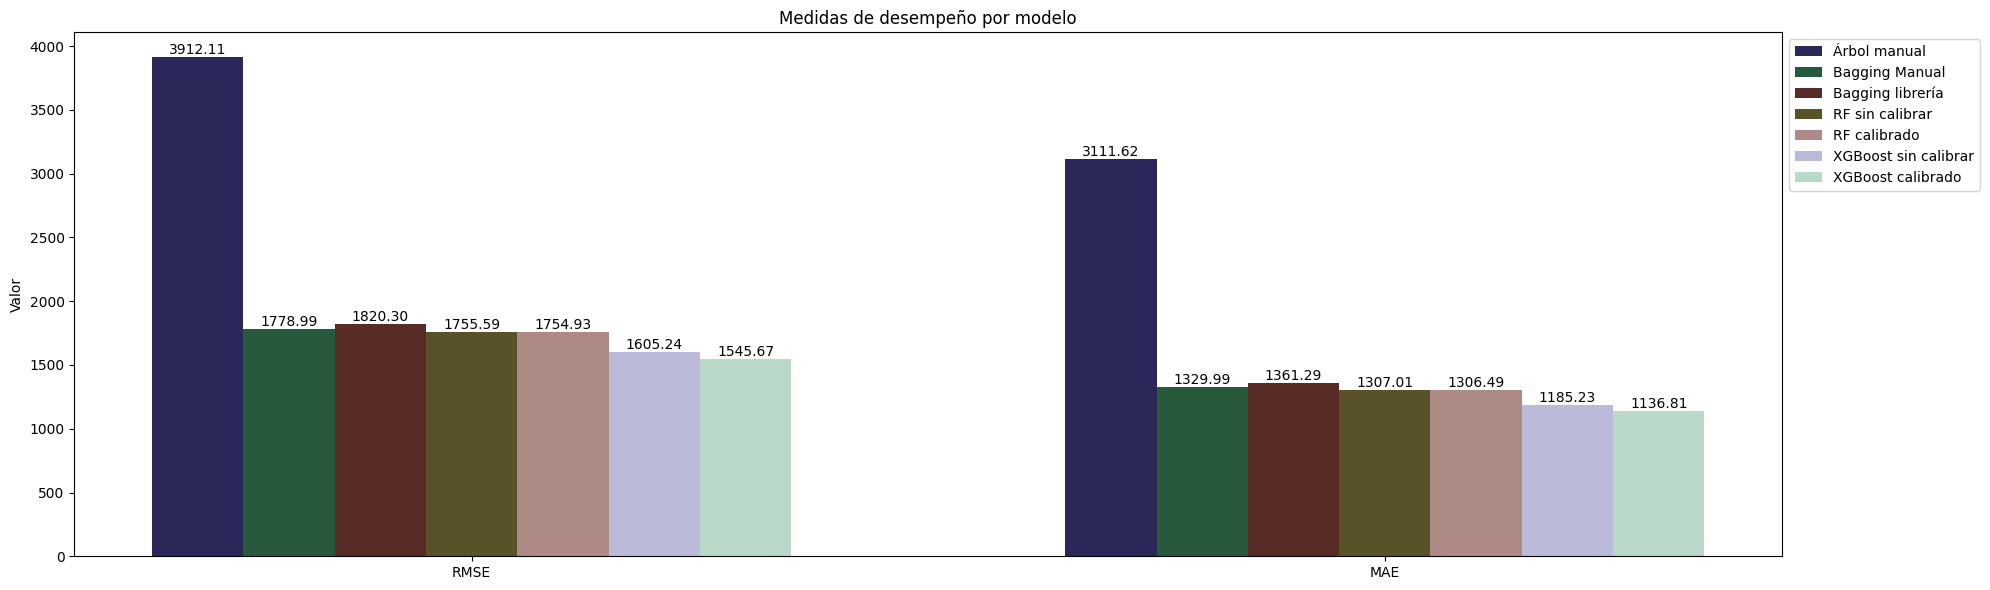

In [19]:
# Celda 8

# Comparar las evaluaciones de poder predictivo de los diferentes modelos
medidas = [ 'RMSE', 'MAE']
modelos = {
    'Árbol manual':[rmse_treeman, mae_treeman],
    'Bagging Manual':[rmse_bgg_mnl, mae_bgg_mnl],
    'Bagging librería':[rmse_bgg_lib, mae_bgg_lib],
    'RF sin calibrar':[rmse_RF4, mae_RF4],
    'RF calibrado':[rmse_regRF5_def, mae_regRF5_def],
    'XGBoost sin calibrar':[rmse_regXGBoost, mae_regXGBoost],
    'XGBoost calibrado':[rmse_regXGBoost_7, mae_regXGBoost_7]
}

# Formato de colores para las barras
colores_modelos = ['#2B2759', '#27593D', '#592B27', '#595127', '#AE8A87', '#BCBAD9', '#BAD9C8', '#D9D4BA']

# Configuración de las dimensiones de figura
fig, ax = plt.subplots(figsize=(20, 6))
bar_width = 0.1
index = np.arange(len(medidas))

# Graficamos las barras con el valor obtenido en cada modelo para las medidas, redondeado a 2 cifras decimales las etiquetas
for i, (nombre_modelo, valores) in enumerate(modelos.items()):
    etiquetas = [f'{round(valor, 2):.2f}' for valor in valores]  # Redondear valores a 2 decimales y convertir a cadena
    ax.bar(index + i * bar_width, valores, bar_width, label=nombre_modelo, color=colores_modelos[i % len(colores_modelos)])
    for j, etiqueta in enumerate(etiquetas):
        ax.text(index[j] + i * bar_width, valores[j] + 0.01, etiqueta, ha='center', va='bottom')

# Ajustes de la figura
ax.set_xlabel('')
ax.set_ylabel('Valor')
ax.set_title('Medidas de desempeño por modelo')
ax.set_xticks(index + (len(modelos) - 1) * bar_width / 2)
ax.set_xticklabels(medidas)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

**Respuesta 8**


Se obtiene que el mejor modelo es el XGBoost calibrado, esto se debe a que con los parámetros especificados el modelo puede encontrar un equilibrio entre sesgo y varianza, lo que reduce el sobreajuste al conjunto de datos train y generaliza mejor el modelo, esto lo hace mas preciso en las predicciones con el conjunto de datos de test.

Por el contrario el modelo con el peor rendimiento es el modelo de arbol manual este resultado puede estar dado por la falta de ajustes avanzados que una librería ya tiene optimizados a su vez no se tiene la calibración adecuada de los hiperparámetros que permitan tener mayor control sobre variables como tasa de aprendizaje, profundidad de los árboles y número máximo de características a considerar en cada división, de manera que no se considera una forma óptima de realización del modelo

